In [12]:
import numpy as np
import namegenerator
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# dummy lineup class
class Lineup:
    def __init__(self, score, gene=''):
        # name only used to differentiate the lineup
        self.name = namegenerator.gen()
        if len(gene):
            self.gene = gene
        else:
            self.gene = np.random.randint(2, size=20)
        self.combat_power = np.count_nonzero(self.gene == 1)
        self.score = score
        
    def to_dict(self):
        return {"name": self.name, 
                "gene": ''.join(list(map(str, self.gene))),
                "combat_power": self.combat_power,
                "score": self.score}

# dummy battle class
class Battle:
    def __init__(self, lineup_a, lineup_b, result=None):
        self.lineup_a = lineup_a
        self.lineup_b = lineup_b
        self.result = result

# fight - compare number of 1s in the gene
def fight(pair):
    # save battle info for evaluation
    battle = Battle(pair[0], pair[1])
    if pair[0].combat_power > pair[1].combat_power:
        battle.result = 'win'
    else:
        battle.result = 'loss'
    return battle

# evaluation
def evaluate(battle):
    if battle.result == "win":
        battle.lineup_a.score += 1
        battle.lineup_b.score -= 1
    else:
        battle.lineup_a.score -= 1
        battle.lineup_b.score += 1
        
# selection
def select(lineups, elite_rate=0.1):
    num_elite = int(len(lineups)*0.1)    
    scores = [lineup.score for lineup in lineups]
    order = np.argsort(scores)
    sorted_lineups = [lineups[i] for i in order]
    elite = sorted_lineups[len(lineups)-num_elite:]
    mutation_pool = sorted_lineups[num_elite:len(lineups)-num_elite]
    return elite, mutation_pool

# check breedable
def breedable(parents):
    # add two gene sequences
    # if two gene at the same index is different
    # the sum will be 1
    # if more than 1 position is different
    # then they are breedable
    x = parents[0].gene + parents[1].gene
    if np.count_nonzero(x == 1) >= 2:
        return True
    else:
        return False

# breed
def breed(parents):
    score = min(parents[0].score, parents[1].score)
    x = parents[0].gene + parents[1].gene
    idx = np.random.choice(np.where(x==1)[0])
    # in order not to confuse, create copies
    offspring_gene1 = deepcopy(parents[0].gene)
    offspring_gene2 = deepcopy(parents[1].gene)
    offspring_gene1[idx], offspring_gene2[idx] = offspring_gene2[idx], offspring_gene1[idx]
    
    lineup1 = Lineup(score=score, gene=offspring_gene1)
    lineup2 = Lineup(score=score, gene=offspring_gene2)
    
    return lineup1, lineup2

def mutate(lineup, score, prob=0.9):
    gene = deepcopy(lineup.gene)
    
    if np.random.random(1)[0] < prob:
        zero_idx = np.where(gene==0)[0]
        if len(zero_idx) > 0:
            idx = np.random.choice(zero_idx)
            gene[idx] = 1
            return Lineup(score=score, gene=gene)
        else:
            return lineup
    else:
        none_zero_idx = np.where(gene==1)[0]
        if len(none_zero_idx) > 1:
            idx = np.random.choice(none_zero_idx)
            gene[idx] = 1
            return Lineup(score=score, gene=gene)
        else:
            return lineup

In [3]:
if __name__ == "__main__":
    generation_size = 40
    num_generation = 10
    
    population = []
    combat_powers = []
    
    for n in range(num_generation):
        print(f'generation {n}')
        if n==0:
            # initialize 50 lineups with initial score 50
            for i in range(generation_size):
                population.append(Lineup(50))
        
        # form battle pairs
        pairs = np.random.choice(population, size=(int(generation_size/2), 2), replace=False)

        # fight
        battles = []
        for pair in pairs:
            battles.append(fight(pair))

        # evaluate
        list(map(evaluate, battles))
        elite, mutation_pool = select(population)

        offsprings = []
        # when offspring not enough for 10% of the population
        # breed
        while len(offsprings) < len(elite):
            # select parent pairs for breeding
            parents_pairs = np.random.choice(elite, size=(int(len(elite)/2),2), replace=False)
            for parents in parents_pairs:
                # pre-pregancy checkup
                if breedable(parents):
                    lineup1, lineup2 = breed(parents)
                    offsprings.append(lineup1)
                    if len(offsprings) < len(elite):
                        offsprings.append(lineup2)
                else:
                    offsprings.append(mutate(parents[0], parents[0].score))
                    if len(offsprings) < len(elite):
                        offsprings.append(mutate(parents[1], parents[1].score))

        mutates = []
        cutoff_score = mutation_pool[0].score
        for lineup in mutation_pool:
            mutates.append(mutate(lineup, cutoff_score))
            
        population = []
        population.extend(elite)
        population.extend(offsprings)
        population.extend(mutates)
        
        combat_powers.append([x.combat_power for x in population])

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


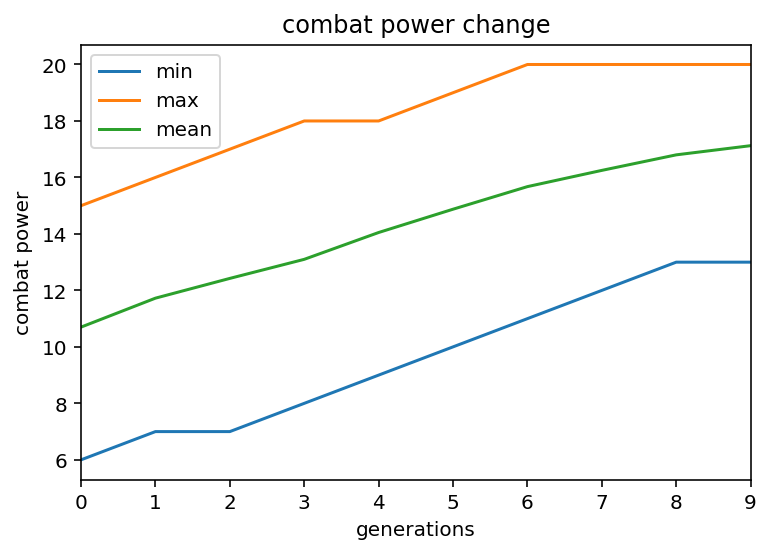

In [19]:
pd.DataFrame(list(zip(*combat_powers)), columns=range(num_generation)).describe().T[['min','max','mean']].plot()
ax = plt.gca()
ax.set_title('combat power change')
ax.set_xlabel('generations')
ax.set_ylabel('combat power')
plt.savefig('combat_power_change.jpg', dpi=300)